In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import os
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

In [2]:
## Φόρτωση συνόλου δεδομένων
url = "https://raw.githubusercontent.com/kdemertzis/EKPA/refs/heads/main/Data/DarkNet.csv"
data = pd.read_csv(url)

<ipython-input-2-8e327f9e84bd>:3: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(url)


# Προεπεξεργασία Δεδομένων

In [3]:
## Εξερεύνηση δεδομένων
data

,Src_IP,Src_Port,Dst_IP,Dst_Port,Protocol,Flow_Duration,Total_Fwd_Packet,Total_Bwd_packets,Total_Length_of_Fwd_Packet,Total_Length_of_Bwd_Packet,...,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label-1,Label-2
0,10.152.152.11,57158,216.58.220.99,443,6,229,1,1,0,0,...,0,0,0,0,0,0.000000e+00,0,0,Non-Tor,AUDIO-STREAMING
1,10.152.152.11,57159,216.58.220.99,443,6,407,1,1,0,0,...,0,0,0,0,0,0.000000e+00,0,0,Non-Tor,AUDIO-STREAMING
2,10.152.152.11,57160,216.58.220.99,443,6,431,1,1,0,0,...,0,0,0,0,0,0.000000e+00,0,0,Non-Tor,AUDIO-STREAMING
3,10.152.152.11,49134,74.125.136.120,443,6,359,1,1,0,0,...,0,0,0,0,0,0.000000e+00,0,0,Non-Tor,AUDIO-STREAMING
4,10.152.152.11,34697,173.194.65.127,19305,6,10778451,591,400,64530,6659,...,0,0,0,0,1437760000000000,3.117718e+06,1437760000000000,1437760000000000,Non-Tor,AUDIO-STREAMING
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68575,10.8.8.246,55219,224.0.0.252,5355,17,411806,2,0,44,0,...,0,0,0,0,0,0.000000e+00,0,0,VPN,VOIP
68576,10.8.8.246,64207,224.0.0.252,5355,17,411574,2,0,44,0,...,0,0,0,0,0,0.000000e+00,0,0,VPN,VOIP
68577,10.8.8.246,61115,224.0.0.252,5355,17,422299,2,0,44,0,...,0,0,0,0,0,0.000000e+00,0,0,VPN,VOIP
68578,10.8.8.246,64790,224.0.0.252,5355,17,411855,2,0,44,0,...,0,0,0,0,0,0.000000e+00,0,0,VPN,VOIP


Παρατηρώ ότι η στήλη Label 1 προσδιορίζει αν το αίτημα προέρχεται από Tor ή όχι. Θα υλοποιήσω έναν ταξινομητή για να προβλέπει αυτό το χαρακτηριστικό. Αφαιρώ τις γραμμές που δεν ανήκουν στις κλάσεις Tor ή Non Tor.

In [4]:
data = data[~data["Label-1"].isin(["VPN", "NonVPN"])]

In [201]:
## a = data[data["Label-1"] == "Tor"]

In [5]:
redundant_columns = [c for c in data.columns.values.tolist() if data[c].nunique() == 1]

print(*redundant_columns, sep = '\n')

Bwd_PSH_Flags
Fwd_URG_Flags
Bwd_URG_Flags
URG_Flag_Count
CWE_Flag_Count
ECE_Flag_Count
Fwd_Bytes/Bulk_Avg
Fwd_Packet/Bulk_Avg
Fwd_Bulk_Rate_Avg
Bwd_Bytes/Bulk_Avg
Subflow_Bwd_Packets
Active_Mean
Active_Std
Active_Max
Active_Min


Οι ανωτέρω στήλες δεν είναι χρήσιμες για την ταξινόμηση καθώς όλα τα στοιχεία του συνόλου δεδομένων έχουν ίδια τιμή σε κάθε μία από αυτές. Επομένως αφαιρούνται.

In [6]:
data = data.drop(redundant_columns, axis = 1)

Μετατροπή διευθύνσεων IP (string) σε αριθμούς ώστε να είναι αναγνωρίσιμες από το νευρωνικό δίκτυο

In [7]:
## https://stackoverflow.com/a/9591005
import socket, struct

def ip2long(ip):
    """
    Convert an IP string to long
    """
    packedIP = socket.inet_aton(ip)
    return struct.unpack("!L", packedIP)[0]

In [8]:
ip2long("10.8.8.246	")

168298742

In [9]:
data['Src_IP'] = list(map(ip2long, data['Src_IP']))
data['Dst_IP'] = list(map(ip2long, data['Dst_IP']))

Αφαίρεση γραμμών με ημιτελή - κακοσχηματισμένα δεδομένα

In [10]:
def identify_non_real_values(df):
    # Check for NaN or None values
    is_nan = df.isna()

    # Check for other non-numeric values (e.g., strings)
    is_not_numeric = df.applymap(lambda x: pd.to_numeric(x, errors='coerce')).isna() & ~df.isna()

    # Combine all checks
    non_real_mask = is_nan | is_not_numeric

    # Get the indices of the non-real values
    non_real_indices = non_real_mask.stack().loc[lambda x: x].index.tolist()

    return list(non_real_indices)

In [11]:
nrv = identify_non_real_values(data.drop(["Label-1", "Label-2"], axis = 1))
## print(*nrv, sep = '\n')

<ipython-input-10-d61a24cde9a4>:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  is_not_numeric = df.applymap(lambda x: pd.to_numeric(x, errors='coerce')).isna() & ~df.isna()


In [ ]:
for r, c in nrv:
    print(data.loc[r, c])

Ορισμένες γραμμές περιέχουν εσφαλμένες τιμές στην στήλη "Flow_Bytes/s". Αυτές αφαιρούνται.

In [12]:
data = data.drop([r for r, _ in nrv], axis = 0)

Ορισμένες γραμμές περιέχουν αριθμητικές τιμές πολύ μεγάλες για τον τύπο float64 που χρησιμοποιούν τα μοντέλα.

In [13]:
data = data[~data.isin([np.nan, np.inf, -np.inf]).any(axis = 1)]

Κατανομή τιμών στην στήλη ταξινόμησης:

In [14]:
data['Label-1'].unique()

array(['Non-Tor', 'Tor'], dtype=object)

<ipython-input-15-158816329ea9>:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(data['Label-1'], sort = True)


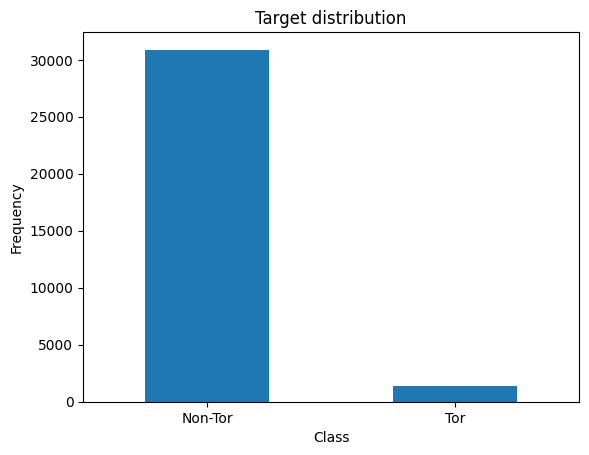

In [15]:
## Κατανομή της εξαρτημένης μεταβλητής
count_classes = pd.value_counts(data['Label-1'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Target distribution")
plt.xticks(range(2), ['Non-Tor', 'Tor'])
plt.xlabel("Class")
plt.ylabel("Frequency");

In [16]:
## Προσθήκη στήλης με κατηγορικές τιμές για την εξαρτημένη μεταβλητή
data["Label-1-cat"] = pd.Categorical(data["Label-1"]).codes

### Διαχωρισμός συνόλων δεδομένων

In [17]:
## Διαχωρισμός ανεξάρτητων και εξαρτημένων μεταβλητών
X = data.drop(["Label-1", "Label-2", "Label-1-cat"], axis = 1)
Y = data["Label-1-cat"]

Κανονικοποίηση αριθμητικών τιμών στο διάστημα $[0,1]$ ούτως ώστε να λειτουργήσουν οι ταξινομητές.

In [18]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled = scaler.fit_transform(X)

X = pd.DataFrame(scaled, columns=X.columns,index=X.index)

In [19]:
## Διαχωρισμός συνόλου δεδομένων σε σύνολο εκπαίδευσης και δοκιμών
## Ως συνήθως επιλέγεται μέγεθος test set το 20% του συνόλου
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

# Ορισμός μοντέλων

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

knn = KNeighborsClassifier()
lr = LogisticRegression()
mlp = MLPClassifier()

# Εκπαίδευση

In [21]:
knn.fit(x_train, y_train)

KNeighborsClassifier()

In [26]:
lr.fit(x_train, y_train)

LogisticRegression()

In [27]:
mlp.fit(x_train, y_train)

MLPClassifier()

# Αξιολόγηση

### K Nearest Neighbors

In [22]:
knn_pred = knn.predict(x_test)

In [24]:
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6180
           1       1.00      0.97      0.98       276

    accuracy                           1.00      6456
   macro avg       1.00      0.99      0.99      6456
weighted avg       1.00      1.00      1.00      6456



<Axes: >

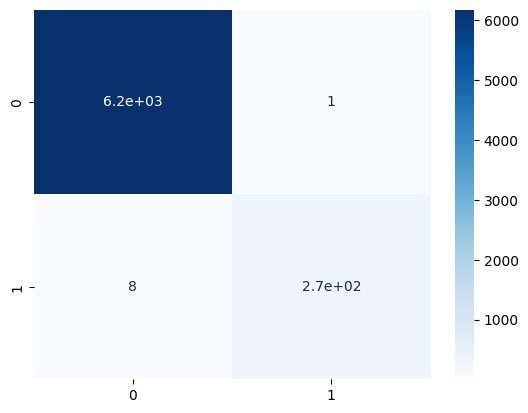

In [25]:
sns.heatmap(confusion_matrix(y_test, knn_pred), annot = True, cmap = "Blues")

### Logistic Regression

In [28]:
lr_pred = lr.predict(x_test)

In [29]:
print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6180
           1       1.00      0.90      0.94       276

    accuracy                           1.00      6456
   macro avg       1.00      0.95      0.97      6456
weighted avg       1.00      1.00      1.00      6456



<Axes: >

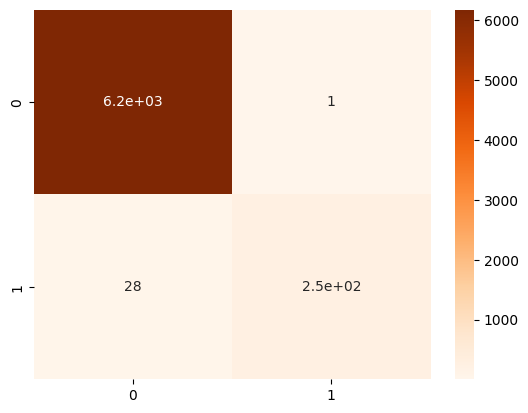

In [30]:
sns.heatmap(confusion_matrix(y_test, lr_pred), annot = True, cmap = "Oranges")

### Multi Layer Perception

In [31]:
mlp_pred = mlp.predict(x_test)

In [32]:
print(classification_report(y_test, mlp_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6180
           1       1.00      0.98      0.99       276

    accuracy                           1.00      6456
   macro avg       1.00      0.99      1.00      6456
weighted avg       1.00      1.00      1.00      6456



<Axes: >

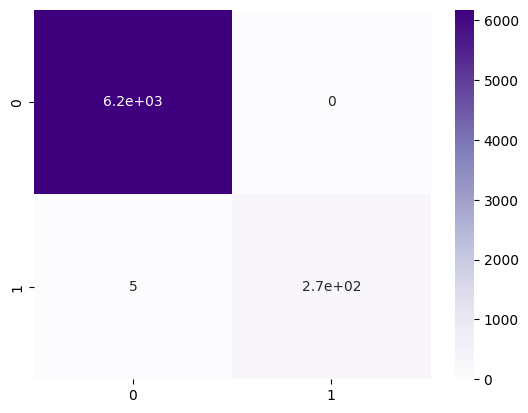

In [33]:
sns.heatmap(confusion_matrix(y_test, mlp_pred), annot = True, cmap = "Purples")